In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload
print("Checkpoint 1")

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer as gtu
print("Checkpoint 2")

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
print("Checkpoint 3")

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()
print("Checkpoint 4")

Checkpoint 1


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoint 2
Checkpoint 3
Checkpoint 4


# Load the model

In [31]:
if torch.cuda.is_available(): 
    print("CUDA is available! Devices: ", torch.cuda.device_count()) 
    print("Current CUDA device: ", torch.cuda.current_device()) 
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device())) 
else: print("CUDA is not available")

CUDA is available! Devices:  1
Current CUDA device:  0
Device name:  NVIDIA A100 80GB PCIe MIG 3g.40gb


In [32]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/"
model = gtu.load_model(model_path)
print('loaded!')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded!


In [33]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,<pad>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,<mask>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ENSG00000000003,2,TSPAN6,2.001186,15.0,protein_coding,X,100627107.0,100639991.0,False
3,ENSG00000000005,3,TNMD,3.228213,6.0,protein_coding,X,100584935.0,100599885.0,False
4,ENSG00000000419,4,DPM1,2.218874,14.0,protein_coding,20,50934866.0,50959140.0,False


# Load data

In [34]:
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/hsc.dataset"

# Load from pre-trained data
raw_data = load_from_disk(data_path)

# Convert to DataFrame for filtering
df = raw_data.to_pandas()
print("\nOriginal Dataset:")
print(f"  - Number of samples: {df.shape[0]:,}")
print(f"  - Number of columns: {df.shape[1]:,}")

# Cell types to filter on
cell_types = ['HSC', 'Fibroblast']

# Filtering
df = df[df['standardized_cell_type'].isin(cell_types)]

# sampling 
sample_size = 2000

df = df.sample(sample_size)
df = df.reset_index(drop=True)

# add a cell id
df['cell_id'] = [f"cell_{i+1}" for i in range(len(df))]

print("\nFiltered Dataset:")
print(f"  - Number of samples: {df.shape[0]:,}")   # Nicer formatting with commas
print(f"  - Number of columns: {df.shape[1]:,}")

# Value counts with sorting
print("\nCell Type Distribution (Filtered):")
print(df['standardized_cell_type'].value_counts().sort_index())  # Sort for readability

# Convert back to Dataset
data = Dataset.from_pandas(df)
print(f"\nDataset converted back: {data}")


Original Dataset:
  - Number of samples: 214,715
  - Number of columns: 8

Filtered Dataset:
  - Number of samples: 2,000
  - Number of columns: 9

Cell Type Distribution (Filtered):
standardized_cell_type
Fibroblast     861
HSC           1139
Name: count, dtype: int64

Dataset converted back: Dataset({
    features: ['input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'],
    num_rows: 2000
})


# Compute HSC mean and plot

In [35]:
hsc_df = df[df['standardized_cell_type'] == 'HSC'].reset_index(drop=True)
hsc_data = Dataset.from_pandas(hsc_df)

reload(gtu)
torch.cuda.empty_cache()
hsc_embs = gtu.extract_embedding_in_mem(
    model, 
    hsc_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{hsc_embs.shape=}")

# translate into an anndata object and plot
hsc_adata = gtu.embedding_to_adata(hsc_embs)
hsc_adata.obs = hsc_df.copy()

sc.tl.pca(hsc_adata, n_comps=25)
sc.pp.neighbors(hsc_adata, n_neighbors=200)
sc.tl.umap(hsc_adata, 
           min_dist=0.75,
          )

hsc_adata

100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


hsc_embs.shape=(1139, 512)


AnnData object with n_obs × n_vars = 1139 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

hsc_mean.shape=(512, 1)


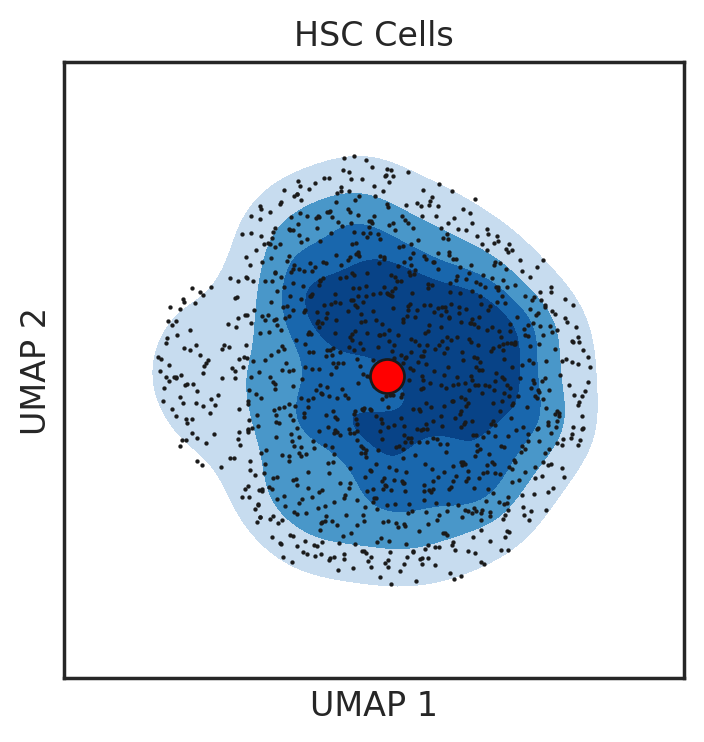

In [36]:
# create the true mean vector based on the embedding space
hsc_mean = hsc_adata.X.mean(axis=0)
hsc_mean = hsc_mean.reshape(-1, 1)
print(f"{hsc_mean.shape=}")


# plot the cells around the mean
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Add Contour Plot
x = hsc_adata.obsm['X_umap'][:, 0]
y = hsc_adata.obsm['X_umap'][:, 1]

# Create a grid for density estimation
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Calculate kernel density estimation and plot
z = sns.kdeplot(x=x, y=y, levels=5, thresh=0.1, cmap="Blues", fill=True)

# Set zorder to place the contour behind the scatter points
z.collections[0].set_zorder(0) 

# Plot scatterplot on top of the contour
sns.scatterplot(
    data=hsc_adata.obs,
    x=hsc_adata.obsm['X_umap'][:, 0],
    y=hsc_adata.obsm['X_umap'][:, 1],
    color='k',
    ec='k',
    s=2,
    zorder=1
)

# Plot the mean point
sns.scatterplot(
    x=[hsc_adata.obsm['X_umap'][:, 0].mean()],
    y=[hsc_adata.obsm['X_umap'][:, 1].mean()],
    color='red',
    ec='k',
    s=150,
    zorder=2  # Set zorder to place the mean point on top
)

# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('HSC Cells')

# Display the plot
plt.show()

# Plot the Fibroblast data

In [37]:
fb_df = df[df['standardized_cell_type'] == 'Fibroblast'].reset_index(drop=True)
fb_data = Dataset.from_pandas(fb_df)

reload(gtu)
torch.cuda.empty_cache()
fb_embs = gtu.extract_embedding_in_mem(
    model, 
    fb_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{fb_embs.shape=}")

# translate into an anndata object and plot
fb_adata = gtu.embedding_to_adata(fb_embs)
fb_adata.obs = fb_df.copy()

sc.tl.pca(fb_adata, n_comps=25)
sc.pp.neighbors(fb_adata, n_neighbors=200)
sc.tl.umap(fb_adata, 
           min_dist=0.75,
          )

fb_adata

100%|██████████| 9/9 [00:32<00:00,  3.64s/it]


fb_embs.shape=(861, 512)


AnnData object with n_obs × n_vars = 861 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

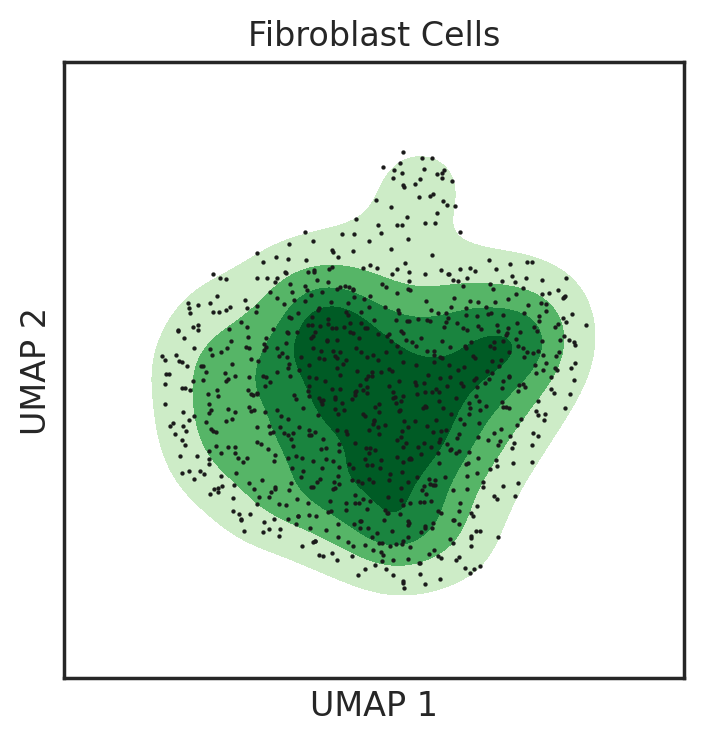

In [38]:
# plot the cells around the mean
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Add Contour Plot
x = fb_adata.obsm['X_umap'][:, 0]
y = fb_adata.obsm['X_umap'][:, 1]

# Create a grid for density estimation
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                             np.linspace(y.min(), y.max(), 100))

# Calculate kernel density estimation and plot
z = sns.kdeplot(x=x, y=y, levels=5, thresh=0.1, cmap="Greens", fill=True)

# Set zorder to place the contour behind the scatter points
z.collections[0].set_zorder(0) 

# Plot scatterplot on top of the contour
sns.scatterplot(
    data=fb_adata.obs,
    x=fb_adata.obsm['X_umap'][:, 0],
    y=fb_adata.obsm['X_umap'][:, 1],
    color='k',
    ec='k',
    s=2,
    zorder=1
)


# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('Fibroblast Cells')

# Display the plot
plt.show()

# Plot them together

In [10]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.umap(adata, 
           min_dist=0.75,
          )
adata

100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


embs.shape=(2000, 512)


AnnData object with n_obs × n_vars = 2000 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

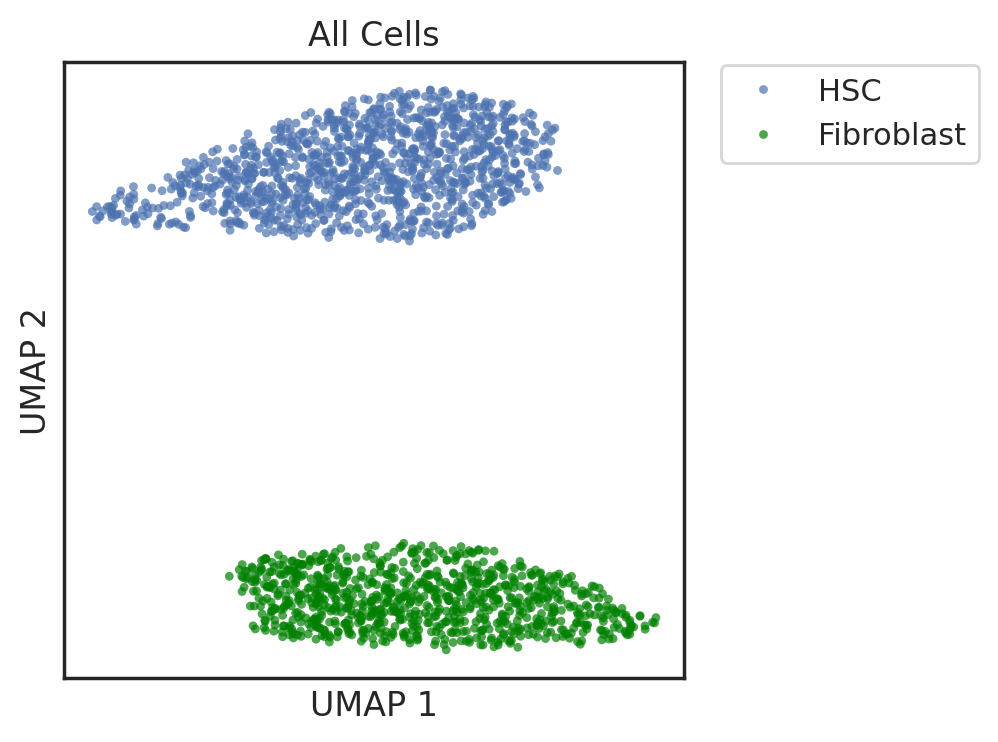

IOStream.flush timed out


In [11]:
sns.scatterplot(
    data=adata.obs,
    x=adata.obsm['X_umap'][:, 0],
    y=adata.obsm['X_umap'][:, 1],
    hue='standardized_cell_type',
    ec='none',
    palette=['C0', 'Green'],
    s=10,
    alpha=0.7,
    zorder=1
)

# Add plot details
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.5, 1.02),
)

# pre-compute cell-cell distances

In [12]:
def make_colorbar(cmap='viridis', 
                  width=0.2,
                  height=2.5, 
                  title='', 
                  orientation='vertical', 
                  tick_labels=[0, 1]):
    """
    Creates and displays a standalone colorbar using Matplotlib.

    Args:
        cmap (str or matplotlib.colors.Colormap): The colormap to use for the colorbar.
        width (float): The width of the colorbar figure in inches.
        height (float): The height of the colorbar figure in inches.
        title (str): The title to display above or next to the colorbar.
        orientation (str): The orientation of the colorbar ('vertical' or 'horizontal').
        tick_labels (list of str): The labels to display at each tick on the colorbar.

    Returns:
        None: This function displays the colorbar directly using Matplotlib.

    Raises:
        ValueError: If the `orientation` is not 'vertical' or 'horizontal'.
    """
    
    a = np.array([[0, 1]])  # Dummy data for the image
    plt.figure(figsize=(width, height))
    img = plt.imshow(a, cmap=cmap)
    plt.gca().set_visible(False)  # Hide the axes of the image
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])  # Define the colorbar position

    ticks = np.linspace(0, 1, len(tick_labels)) 
    cbar = plt.colorbar(
        orientation=orientation,
        cax=cax,
        label=title,
        ticks=ticks
    )

    if orientation == 'vertical':
        cbar.ax.set_yticklabels(tick_labels)
    elif orientation == 'horizontal':
        cbar.ax.set_xticklabels(tick_labels)

X.shape=(2000, 512)
D.shape=(2000, 2000)


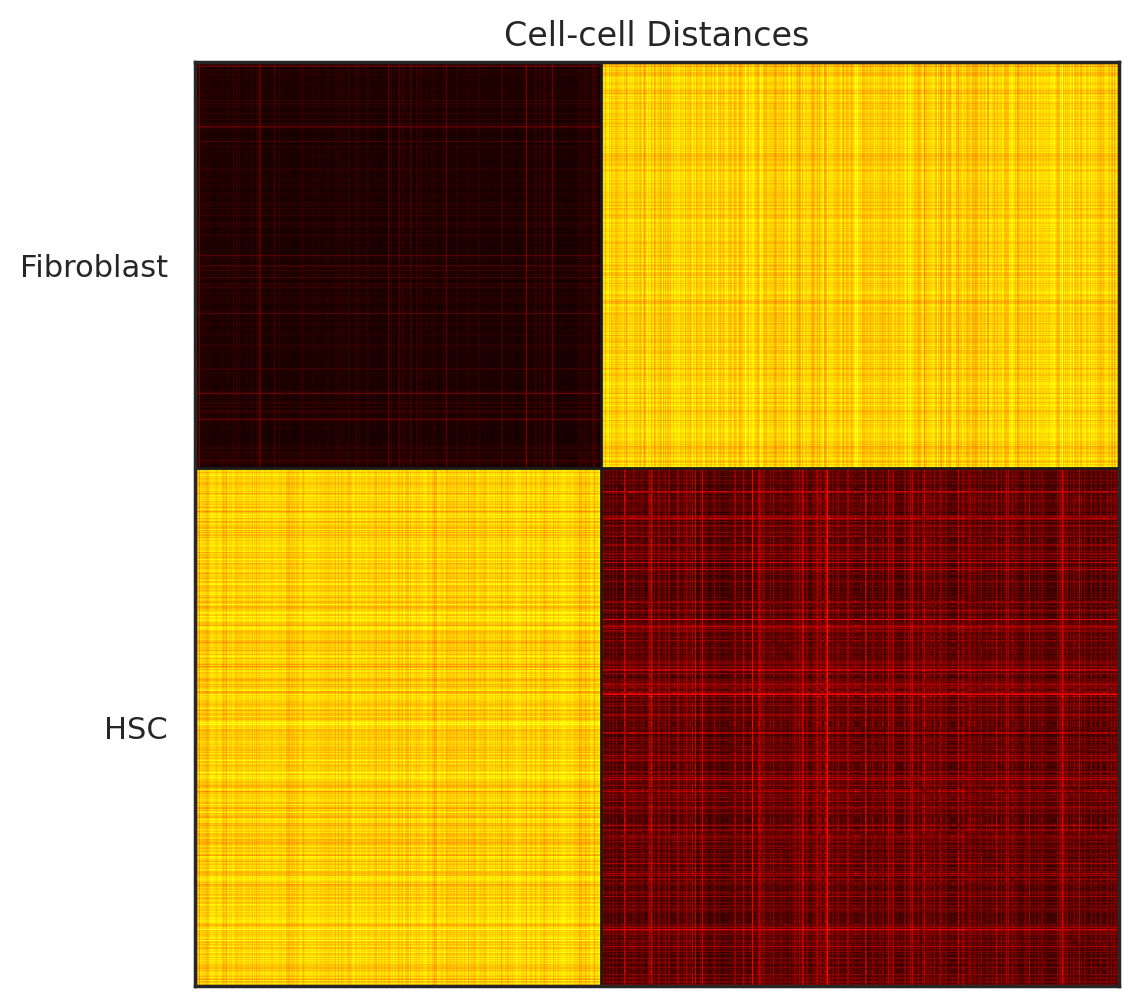

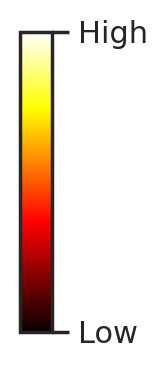

In [13]:
# sort by cell-type

"""
In this block I compute the consine distance in embedding space between all fibroblasts and all hsc cells
"""

sorted_cells = adata.obs.sort_values(by='standardized_cell_type')
change_indices = np.argwhere(sorted_cells['standardized_cell_type'] != sorted_cells['standardized_cell_type'].shift(1))
change_indices = np.ravel(change_indices)
X = adata[sorted_cells.index, :].X
print(f"{X.shape=}")

metric = 'cosine'
cmap = 'hot'
D = squareform(pdist(X, metric=metric))
print(f"{D.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6
plt.imshow(D, cmap=cmap)

# add dividing lines
for pos in change_indices[1:]:
    plt.axvline(x=pos, c='k', lw=1)
    plt.axhline(y=pos, c='k', lw=1)
    
# label the blocks
all_indices = list(change_indices) + [len(X)]
midpoints = [(all_indices[i] + all_indices[i + 1]) / 2 for i in range(len(all_indices) - 1)]
plt.yticks(midpoints, sorted_cells['standardized_cell_type'].unique())

plt.title('Cell-cell Distances')
plt.xticks([])

make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])

# Visualize the variability

hsc_dists.shape=(1147, 1147)


Text(0.5, 1.0, 'HSC-HSC Distances')

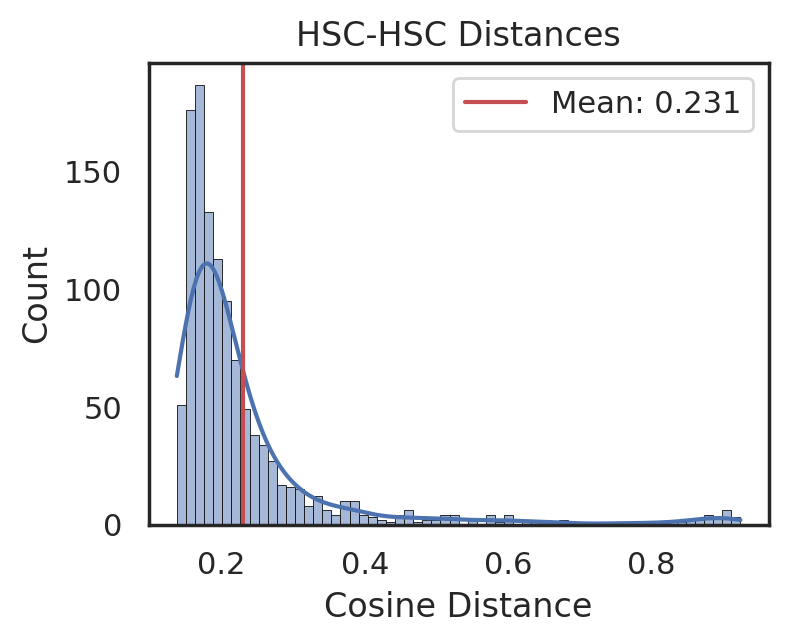

In [14]:
""" Compute the hsc-hsc distances """
hsc_dists = D[853:2000, 853:2000]
print(f"{hsc_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=hsc_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C0',
)

# add mean distance
x = hsc_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('HSC-HSC Distances')

fb_dists.shape=(853, 853)


Text(0.5, 1.0, 'FB-FB Distances')

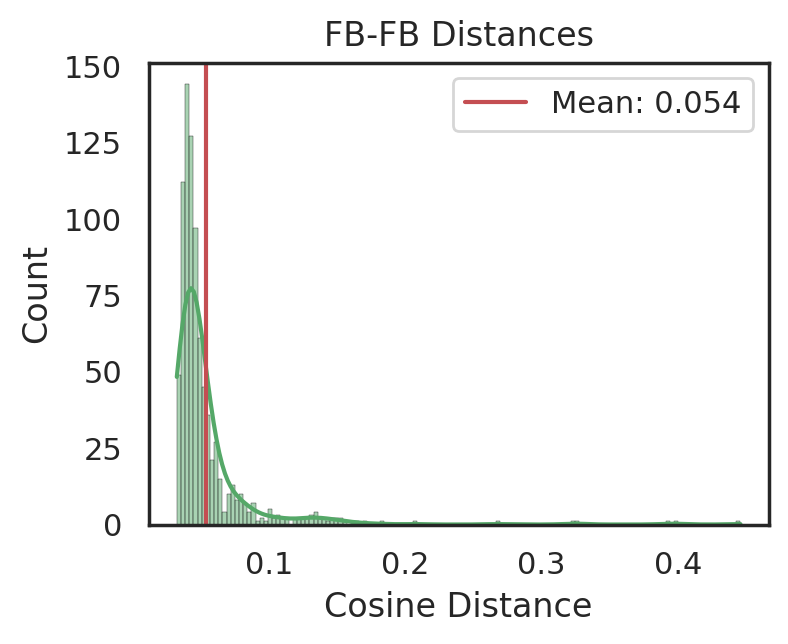

In [15]:
""" Compute the fibroblast-fibroblast distances """
fb_dists = D[0:853, 0:853]
print(f"{fb_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=fb_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C2',
)

# add mean distance
x = fb_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('FB-FB Distances')

fb_hsc_dists.shape=(853, 1147)


Text(0.5, 1.0, 'FB-HSC Distances')

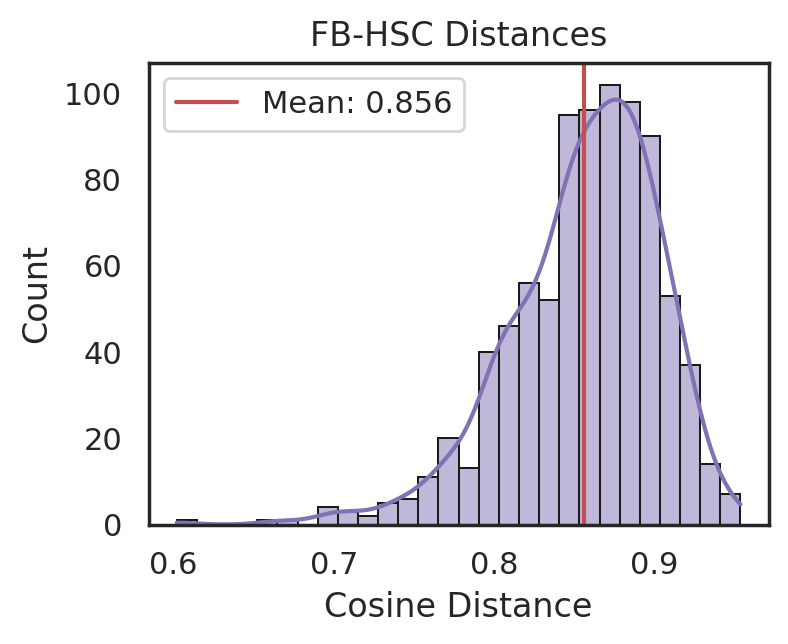

In [16]:
""" Compute the fibroblast-hsc distances """
fb_hsc_dists = D[0:853, 853:2000]
print(f"{fb_hsc_dists.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    x=fb_hsc_dists.mean(axis=1),
    ec='k',
    kde=True,
    color='C4',
)

# add mean distance
x = fb_hsc_dists.mean(axis=1).mean()
plt.axvline(x=x, c='r', label=f"Mean: {x:.3f}")
plt.legend()

plt.xlabel('Cosine Distance')
plt.title('FB-HSC Distances')

# Pertrubations

In [17]:
gene_list = [
    'GATA2', 
    'GFI1B', 
    'FOS', 
    'STAT5A',
    'REL',
    'FOSB',
    'IKZF1',
    'RUNX3',
    'MEF2C',
    'ETV6',
]

genes = token_df[token_df['gene_name'].isin(gene_list)]
tf_map = dict(zip(genes['token_id'].values, genes['gene_name'].values))

genes

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
404,ENSG00000020633,404,RUNX3,3.195369,19.0,protein_coding,1,24899510.0,24965121.0,True
1532,ENSG00000081189,1532,MEF2C,7.818396,16.0,protein_coding,5,88717116.0,88904257.0,True
5675,ENSG00000125740,5675,FOSB,5.344128,14.0,protein_coding,19,45467994.0,45475179.0,True
5806,ENSG00000126561,5806,STAT5A,2.177263,18.0,protein_coding,17,42287546.0,42311943.0,True
7725,ENSG00000139083,7725,ETV6,3.312123,11.0,protein_coding,12,11649673.0,11895377.0,True
10804,ENSG00000162924,10804,REL,3.891583,16.0,protein_coding,2,60881490.0,60931612.0,True
11599,ENSG00000165702,11599,GFI1B,2.131079,15.0,protein_coding,9,132943999.0,132991687.0,True
12698,ENSG00000170345,12698,FOS,16.001316,10.0,protein_coding,14,75278825.0,75282230.0,True
14409,ENSG00000179348,14409,GATA2,2.523616,13.0,protein_coding,3,128479426.0,128493201.0,True
15641,ENSG00000185811,15641,IKZF1,3.329544,21.0,protein_coding,7,50304067.0,50405101.0,True


# Set up the inputs

In [18]:
# compute all possible combinations of 5 TFs,
n_tf = 5
inputs = list(combinations(genes['token_id'], n_tf))
print(f'Number of recipes: {len(inputs)}')

def map_tfs(tokens):
    return list(map(tf_map.get, tokens))

print(inputs[0])
print(map_tfs(inputs[0]))

Number of recipes: 252
(404, 1532, 5675, 5806, 7725)
['RUNX3', 'MEF2C', 'FOSB', 'STAT5A', 'ETV6']


In [19]:
def add_perturbations_to_cell(cell_tokens, perturbation_tokens):
    """
    Modifies a list of cell tokens by adding perturbation tokens and padding.

    Args:
        cell_tokens (list): A list of integers representing gene tokens.
        perturbation_tokens (list): A list of integers representing perturbation tokens.

    Returns:
        list: A new list of tokens with perturbations added, existing perturbations removed,
             and truncated/padded to the original length.
    """

    original_length = len(cell_tokens)

    # Remove existing perturbation tokens from the cell
    cell_tokens = [token for token in cell_tokens if token not in perturbation_tokens]

    # Add perturbations, then slice or pad to match original length
    final_tokens = (perturbation_tokens + cell_tokens)[:original_length]  # Slice if too long
    final_tokens += [0] * (original_length - len(final_tokens))            # Pad if too short

    return final_tokens


# test
test_cell = df.head(1)['input_ids'].values[0]
perturbed = add_perturbations_to_cell(test_cell, list(inputs[0]))

print(test_cell[:10])
print(perturbed[:10])

[ 8583  9512  9687  7725 14577  8684 17163  3659  4479 18049]
[404, 1532, 5675, 5806, 7725, 8583, 9512, 9687, 14577, 8684]


In [29]:
# set up some perturbations
sample_size = 10

raw_cells = fb_df.sample(sample_size).reset_index(drop=True)
print(f"{raw_cells.shape=}")
raw_cells['recipe'] = 'raw'
raw_cells['type'] = 'initial'

hsc_sample = hsc_df.sample(sample_size).reset_index(drop=True)
hsc_sample['recipe'] = 'hsc'
hsc_sample['type'] = 'target'

reprogramming_df = [
    raw_cells,
    hsc_sample,
]

for i, tfs in enumerate(inputs):
    
    if i % 25 == 0:
        print(f"Pertubation {i}/{len(inputs)}...")
    
    # make the dataframe easily useable
    perturb = raw_cells.copy()
    recipe = ";".join(map_tfs(tfs))
    perturb['recipe'] = recipe
    perturb['type'] = 'reprogrammed'
    
    # do the actual perturbation
    perturb['input_ids'] = perturb['input_ids'].apply(lambda x: add_perturbations_to_cell(x, list(tfs)))
    
    # store the updated data
    reprogramming_df.append(perturb)
    
reprogramming_df = pd.concat(reprogramming_df)
reprogramming_df = reprogramming_df.reset_index(drop=True)
print(f"{reprogramming_df.shape=}")
reprogramming_df.sample(10)

raw_cells.shape=(10, 9)
Pertubation 0/252...
Pertubation 25/252...
Pertubation 50/252...
Pertubation 75/252...
Pertubation 100/252...
Pertubation 125/252...
Pertubation 150/252...
Pertubation 175/252...
Pertubation 200/252...
Pertubation 225/252...
Pertubation 250/252...
reprogramming_df.shape=(2540, 11)


,input_ids,cell_type,dataset,length,ignore,standardized_cell_type,broad_type,__index_level_0__,cell_id,recipe,type
1810,"[1532, 5806, 11599, 14409, 15641, 9009, 16916,...",fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121177,cell_1372,MEF2C;STAT5A;GFI1B;GATA2;IKZF1,reprogrammed
452,"[404, 1532, 7725, 12698, 14409, 10945, 9009, 1...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,159530,cell_240,RUNX3;MEF2C;ETV6;FOS;GATA2,reprogrammed
1645,"[1532, 5806, 7725, 10804, 12698, 3878, 2225, 9...",fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121517,cell_1724,MEF2C;STAT5A;ETV6;REL;FOS,reprogrammed
1725,"[1532, 5806, 7725, 14409, 15641, 3878, 2225, 9...",fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121517,cell_1724,MEF2C;STAT5A;ETV6;GATA2;IKZF1,reprogrammed
208,"[404, 1532, 5675, 12698, 14409, 16916, 5592, 9...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,170334,cell_1936,RUNX3;MEF2C;FOSB;FOS;GATA2,reprogrammed
2000,"[5675, 5806, 7725, 10804, 14409, 9009, 16916, ...",fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121177,cell_1372,FOSB;STAT5A;ETV6;REL;GATA2,reprogrammed
37,"[404, 1532, 5675, 5806, 10804, 9009, 1513, 719...",Myofibroblasts,TS_Fat,1827,Myofibroblasts,Fibroblast,fibroblast,152025,cell_943,RUNX3;MEF2C;FOSB;STAT5A;REL,reprogrammed
952,"[404, 5806, 7725, 10804, 14409, 10945, 9009, 1...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,159530,cell_240,RUNX3;STAT5A;ETV6;REL;GATA2,reprogrammed
248,"[404, 1532, 5806, 7725, 11599, 16916, 5592, 90...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,170334,cell_1936,RUNX3;MEF2C;STAT5A;ETV6;GFI1B,reprogrammed
75,"[404, 1532, 5675, 5806, 15641, 3878, 2225, 900...",fibroblast,TS_Vasculature,2048,fibroblast,Fibroblast,fibroblast,121517,cell_1724,RUNX3;MEF2C;FOSB;STAT5A;IKZF1,reprogrammed


# Perturbation Embedding

In [21]:
reload(gtu)
torch.cuda.empty_cache()

reprogramming_data = Dataset.from_pandas(reprogramming_df)

reprogramming_embs = gtu.extract_embedding_in_mem(
    model, 
    reprogramming_data, 
    layer_to_quant=-1,
    forward_batch_size=100,
)
print(f"{reprogramming_embs.shape=}")

# translate into an anndata object and plot
reprogramming_adata = gtu.embedding_to_adata(reprogramming_embs)
reprogramming_adata.obs = reprogramming_df.copy()

sc.tl.pca(reprogramming_adata, n_comps=25)
sc.pp.neighbors(reprogramming_adata, n_neighbors=200)
sc.tl.umap(reprogramming_adata, 
           min_dist=0.75,
          )

reprogramming_adata

100%|██████████| 26/26 [01:36<00:00,  3.72s/it]


reprogramming_embs.shape=(2540, 512)


AnnData object with n_obs × n_vars = 2540 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__', 'cell_id', 'recipe', 'type'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Plot

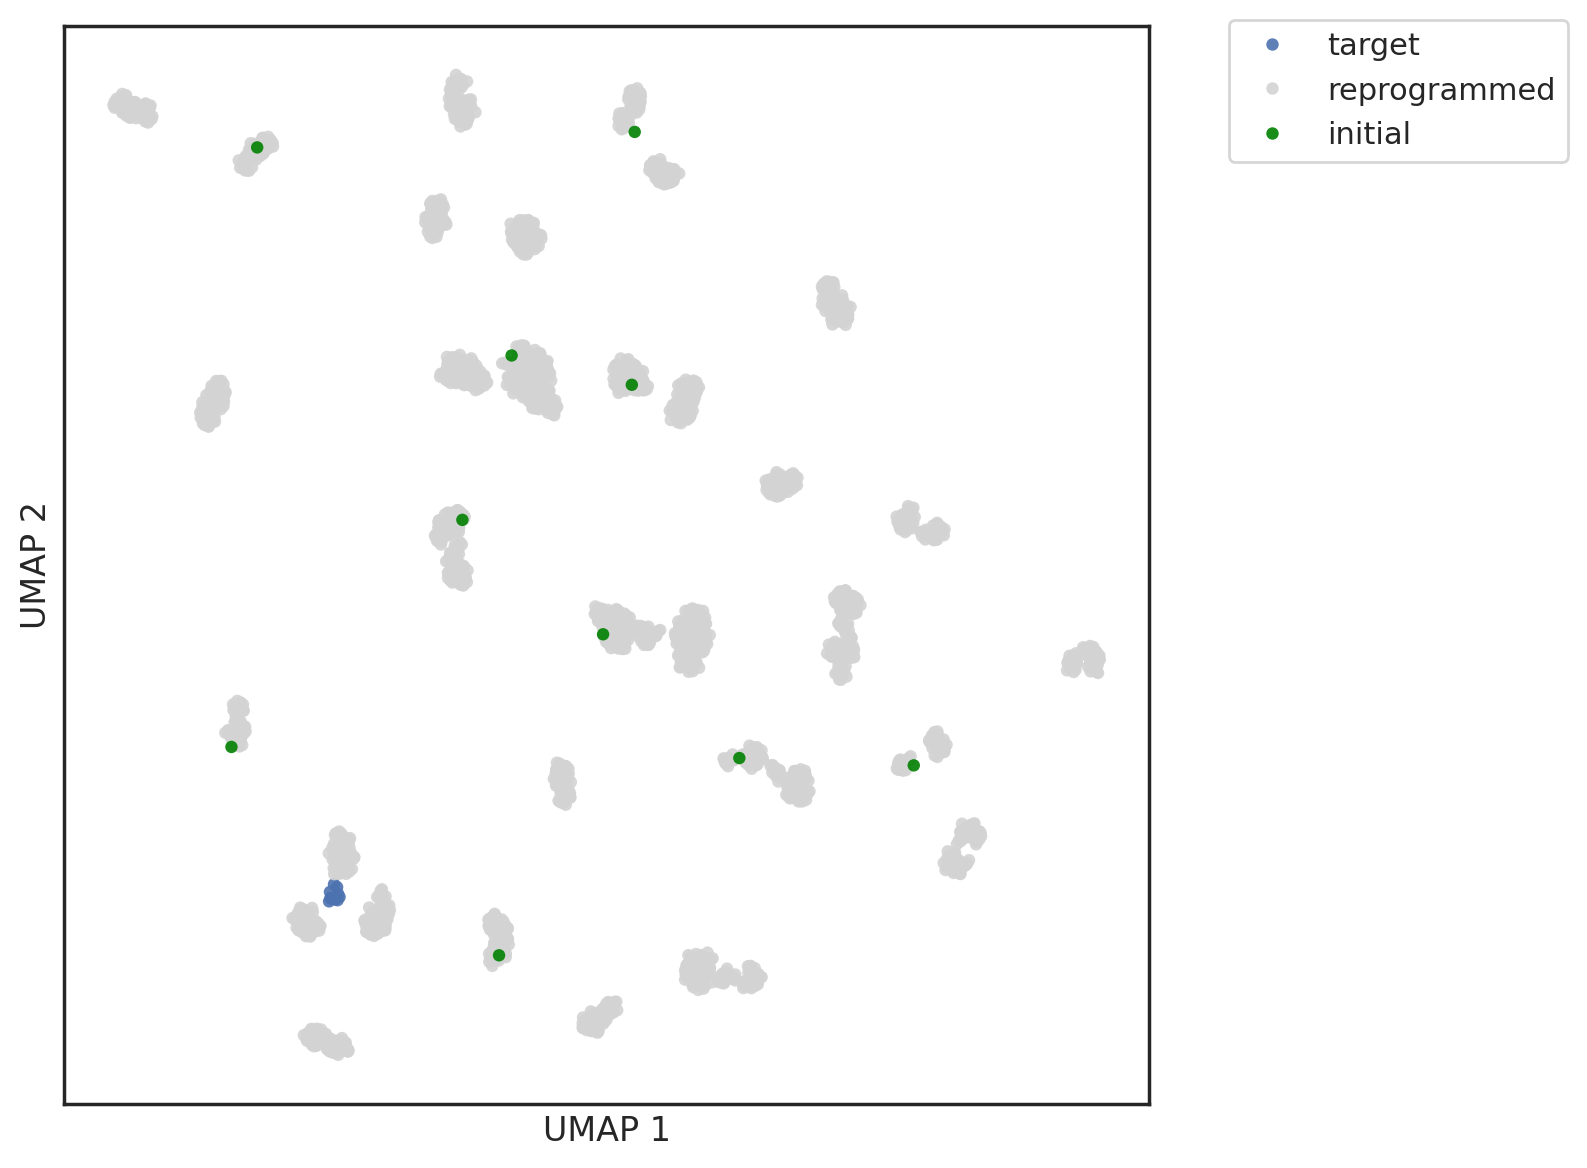

In [22]:
pdf = reprogramming_adata.obs.copy()
pdf['UMAP 1'] = reprogramming_adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = reprogramming_adata.obsm['X_umap'][:, 1]

pdf = pdf.sort_values(by='type', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='type',
    ec='none',
    palette=['C0', 'lightgrey', 'green'],
    s=20,
    alpha=0.9,
    zorder=1
)

# # Add plot details
plt.yticks([])
plt.xticks([])
# # plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.4, 1.02),
)

# minimal distance to target

In [23]:
initial = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'initial']
target = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'target']
repro = reprogramming_adata.obs[reprogramming_adata.obs['type'] == 'reprogrammed']

# precompute all distances
metric = 'cosine'
D = squareform(pdist(reprogramming_adata.X, metric=metric))
print(f"{D.shape=}")

inital_to_target = D[initial.index, target.index].mean()
print(f"{inital_to_target=:.4f}")

result = []

for i, (recipe, group) in enumerate(repro.groupby('recipe')):
    
    if i % 25 == 0:
        print(f"Recipe {i}/{len(inputs)}...")
    
    # compute group to intial
    recipe_to_initial = D[group.index, initial.index].mean() # average over all cells
    
    # compute group to target
    recipe_to_target = D[group.index, target.index].mean() # average over all cells
    
    row = {
        'recipe' : recipe,
        'recipe_to_initial' : recipe_to_initial,
        'recipe_to_target' : recipe_to_target,
        'recipe_diff' : inital_to_target - recipe_to_target,
    }
    result.append(row)
    
result = pd.DataFrame(result)
result.head()

D.shape=(2540, 2540)
inital_to_target=0.8973
Recipe 0/252...
Recipe 25/252...
Recipe 50/252...
Recipe 75/252...
Recipe 100/252...
Recipe 125/252...
Recipe 150/252...
Recipe 175/252...
Recipe 200/252...
Recipe 225/252...
Recipe 250/252...


,recipe,recipe_to_initial,recipe_to_target,recipe_diff
0,ETV6;GFI1B;FOS;GATA2;IKZF1,0.011128,0.885131,0.012162
1,ETV6;REL;FOS;GATA2;IKZF1,0.011013,0.882863,0.014430
2,ETV6;REL;GFI1B;FOS;GATA2,0.010958,0.884169,0.013125
3,ETV6;REL;GFI1B;FOS;IKZF1,0.010705,0.884273,0.013020
4,ETV6;REL;GFI1B;GATA2;IKZF1,0.011359,0.892101,0.005192


In [24]:
result = result.sort_values(by='recipe_diff', ascending=False)
result.head(15)

,recipe,recipe_to_initial,recipe_to_target,recipe_diff
248,STAT5A;REL;FOS;GATA2;IKZF1,0.011510,0.880423,0.016870
104,MEF2C;STAT5A;REL;FOS;GATA2,0.011346,0.881080,0.016214
105,MEF2C;STAT5A;REL;FOS;IKZF1,0.011033,0.881225,0.016068
249,STAT5A;REL;GFI1B;FOS;GATA2,0.011447,0.881630,0.015663
250,STAT5A;REL;GFI1B;FOS;IKZF1,0.011100,0.881770,0.015523
100,MEF2C;STAT5A;FOS;GATA2;IKZF1,0.011371,0.882015,0.015278
86,MEF2C;REL;FOS;GATA2;IKZF1,0.011105,0.882015,0.015278
110,REL;GFI1B;FOS;GATA2;IKZF1,0.011430,0.882446,0.014847
247,STAT5A;GFI1B;FOS;GATA2;IKZF1,0.011611,0.882580,0.014714
241,STAT5A;ETV6;REL;FOS;GATA2,0.011119,0.882668,0.014625


In [25]:
result['recipe_list'] = result['recipe'].str.split(";")
result['recipe_list'] = result['recipe_list'].apply(lambda x: ";".join(sorted(x)))
result['rank'] = result['recipe_diff'].rank(ascending=False)
result.head()

,recipe,recipe_to_initial,recipe_to_target,recipe_diff,recipe_list,rank
248,STAT5A;REL;FOS;GATA2;IKZF1,0.011510,0.880423,0.016870,FOS;GATA2;IKZF1;REL;STAT5A,1.0
104,MEF2C;STAT5A;REL;FOS;GATA2,0.011346,0.881080,0.016214,FOS;GATA2;MEF2C;REL;STAT5A,2.0
105,MEF2C;STAT5A;REL;FOS;IKZF1,0.011033,0.881225,0.016068,FOS;IKZF1;MEF2C;REL;STAT5A,3.0
249,STAT5A;REL;GFI1B;FOS;GATA2,0.011447,0.881630,0.015663,FOS;GATA2;GFI1B;REL;STAT5A,4.0
250,STAT5A;REL;GFI1B;FOS;IKZF1,0.011100,0.881770,0.015523,FOS;GFI1B;IKZF1;REL;STAT5A,5.0


In [26]:
iHSC_tf = [
    'GATA2', 
    'GFI1B', 
    'FOS', 
    'STAT5A',
    'REL',
]

query = ";".join(sorted(iHSC_tf))

result[result['recipe_list'] == query]

,recipe,recipe_to_initial,recipe_to_target,recipe_diff,recipe_list,rank
249,STAT5A;REL;GFI1B;FOS;GATA2,0.011447,0.88163,0.015663,FOS;GATA2;GFI1B;REL;STAT5A,4.0


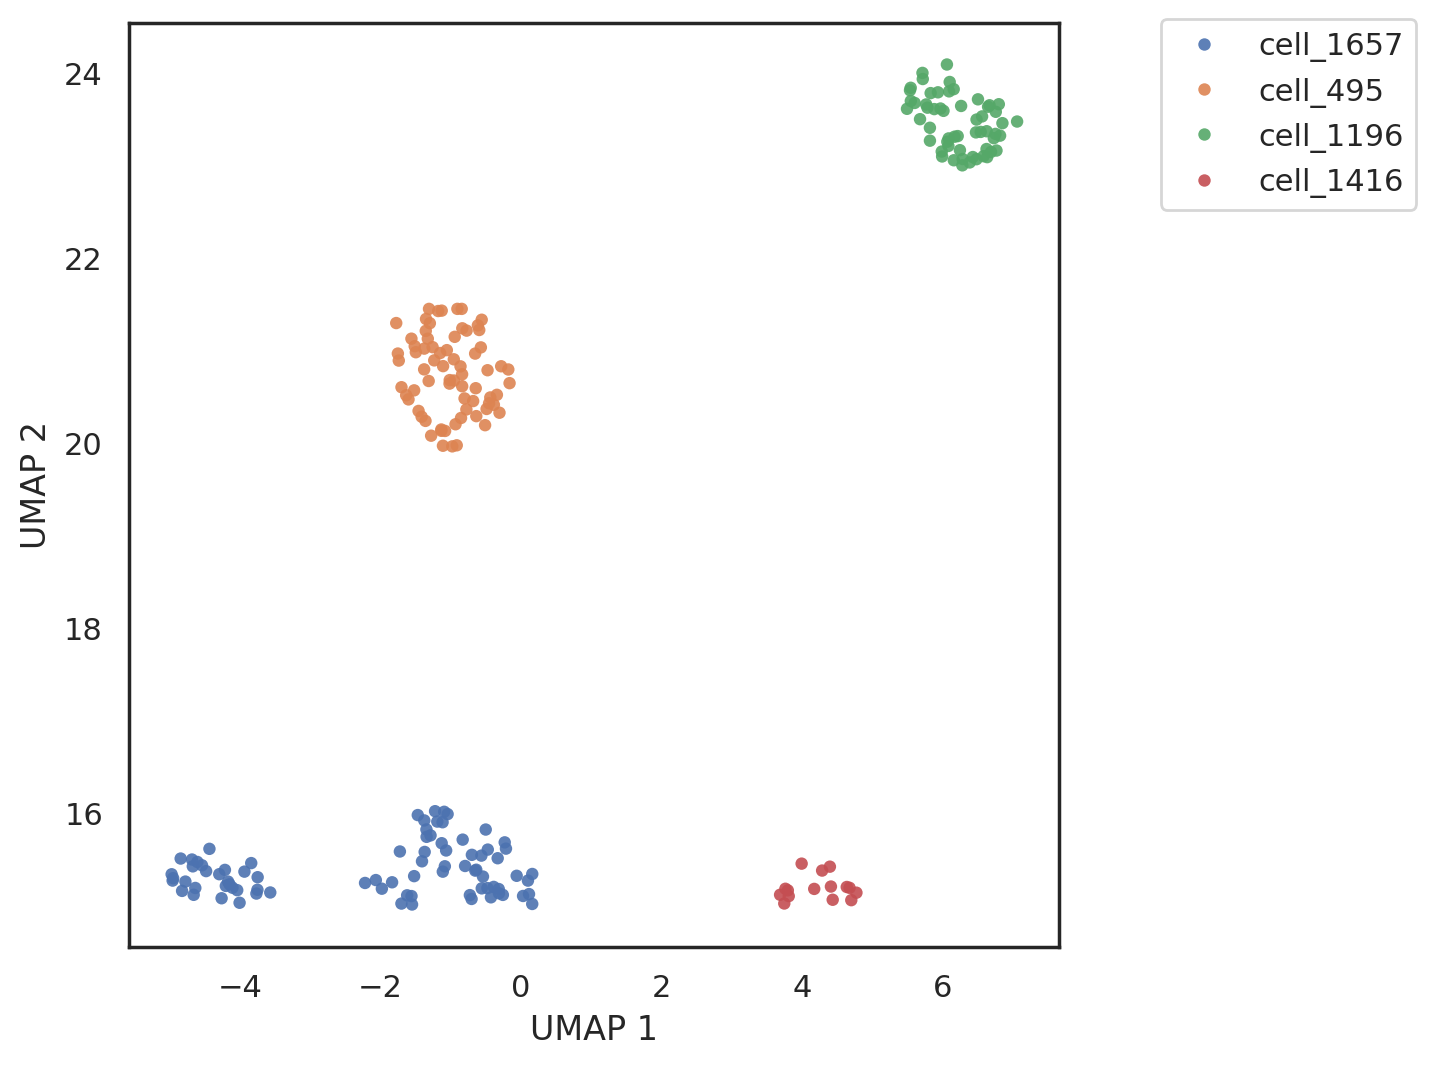

In [27]:
pdf = reprogramming_adata.obs.copy()
pdf['UMAP 1'] = reprogramming_adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = reprogramming_adata.obsm['X_umap'][:, 1]


# # extract the cells by UMAP coords
pdf = pdf[(pdf['UMAP 1'] < 10) & (pdf['UMAP 1'] > -5)]
pdf = pdf[(pdf['UMAP 2'] < 25) & (pdf['UMAP 2'] > 15)]

pdf = pdf.sort_values(by='type', ascending=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=pdf,
    x='UMAP 1',
    y='UMAP 2',
    hue='cell_id',
    ec='none',
    s=20,
    alpha=0.9,
    zorder=1
)

# # Add plot details
# plt.yticks([])
# plt.xticks([])
# # plt.title('All Cells')

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper right',
    bbox_to_anchor=(1.4, 1.02),
)

In [28]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)